In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 加载数据集
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mnist

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000001EEB33F25F8>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000001EEB85D3B70>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000001EEB85D3A20>)

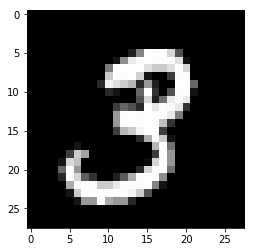

In [24]:
import matplotlib.pyplot as plt
batch = mnist.train.images
plotData = batch[1]
plotData = plotData.reshape(28, 28)
plt.gray() # use this line if you don't want to see it in color
plt.imshow(plotData)

In [81]:
# 以交互式方式启动session
# 如果不使用交互式session，则在启动session前必须
# 构建整个计算图，才能启动该计算图
sess = tf.InteractiveSession()

"""构建计算图"""
# 通过占位符来为输入图像和目标输出类别创建节点
# shape参数是可选的，有了它tensorflow可以自动捕获维度不一致导致的错误
x = tf.placeholder("float", shape=[None, 784])  # 原始输入
y = tf.placeholder("float", shape=[None, 10])  # 目标值

# 为了不在建立模型的时候反复做初始化操作，
# 我们定义两个函数用于初始化
def weight_variable(shape):
    # 截尾正态分布,stddev是正态分布的标准偏差
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# 卷积核池化,步长为1,0边距
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

"""第一层卷积"""
# 由一个卷积和一个最大池化组成。滤波器5x5中算出32个特征，是因为使用32个滤波器进行卷积
# 卷积的权重张量形状是[5, 5, 1, 32],1是输入通道的个数，32是输出通道个数
W_conv1 = weight_variable([5, 5, 1, 32])
# 每一个输出通道都有一个偏置量
b_conv1 = bias_variable([32])

# 位了使用卷积，必须将输入转换成4维向量，2、3维表示图片的宽、高
# 最后一维表示图片的颜色通道（因为是灰度图像所以通道数维1，RGB图像通道数为3）
x_image = tf.reshape(x, [-1, 28, 28, 1])

# 第一层的卷积结果,使用Relu作为激活函数
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1))
# 第一层卷积后的池化结果
h_pool1 = max_pool_2x2(h_conv1)

"""第二层卷积"""
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

"""全连接层"""
# 图片尺寸减小到7*7，加入一个有1024个神经元的全连接层
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
# 将最后的池化层输出张量reshape成一维向量
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
# 全连接层的输出
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

"""使用Dropout减少过拟合"""
# 使用placeholder占位符来表示神经元的输出在dropout中保持不变的概率
# 在训练的过程中启用dropout，在测试过程中关闭dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

"""输出层"""
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
# 模型预测输出
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2,name='y_conv')

# 交叉熵损失
cross_entropy = -tf.reduce_sum(y * tf.log(y_conv))

# 模型训练,使用AdamOptimizer来做梯度最速下降
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 正确预测,得到True或False的List
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_conv, 1),name='y_equal')
# 将布尔值转化成浮点数，取平均值作为精确度
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# 在session中先初始化变量才能在session中调用
sess.run(tf.global_variables_initializer())

# 迭代优化模型
for i in range(600):
    # 每次取50个样本进行训练
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: batch[0], y: batch[1], keep_prob: 1.0})  # 模型中间不使用dropout
        print("step %d, training accuracy %g" % (i, train_accuracy))
    train_step.run(feed_dict={x:batch[0], y:batch[1], keep_prob: 0.5})
print("test accuracy %g" % accuracy.eval(feed_dict={
            x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.08
step 100, training accuracy 0.9
step 200, training accuracy 0.92
step 300, training accuracy 0.94
step 400, training accuracy 0.96
step 500, training accuracy 0.98
test accuracy 0.9502


In [82]:
y_conv.name

'y_conv:0'

In [83]:
from tensorflow.python.framework import graph_util

output_graph_def = graph_util.convert_variables_to_constants(sess, sess.graph_def, output_node_names=['y_conv'])
with tf.gfile.FastGFile('my_model/tfcnnmnist.pb', mode='wb') as f:  # ’wb’中w代表写文件，b代表将数据以二进制方式写入文件。
    f.write(output_graph_def.SerializeToString())

INFO:tensorflow:Froze 7 variables.
Converted 7 variables to const ops.


In [86]:
import tfcoreml as tf_converter
tf_converter.convert(tf_model_path = 'my_model/tfcnnmnist.pb',
                     mlmodel_path = 'my_model/tfcnnmnist.mlmodel',
                     output_feature_names = ['y_conv:0'],
                     input_name_shape_dict = {'x':[None, 784],'Placeholder_2:0':[1, 1024]})


Loading the TF graph...
Graph Loaded.
Done.
Now finding ops in the TF graph that can be dropped for inference
Now starting translation to CoreML graph.
1/44: Analysing op name: Variable_7 ( type:  Const )
2/44: Analysing op name: Variable_7/read ( type:  Identity )
3/44: Analysing op name: Variable_6 ( type:  Const )
4/44: Analysing op name: Variable_6/read ( type:  Identity )
5/44: Analysing op name: dropout/random_uniform/max ( type:  Const )
6/44: Analysing op name: dropout/random_uniform/min ( type:  Const )
7/44: Analysing op name: dropout/random_uniform/sub ( type:  Sub )
8/44: Analysing op name: Placeholder_2 ( type:  Placeholder )
Skipping name of placeholder
9/44: Analysing op name: Reshape_1/shape ( type:  Const )
10/44: Analysing op name: Variable_5 ( type:  Const )
11/44: Analysing op name: Variable_5/read ( type:  Identity )
12/44: Analysing op name: Variable_4 ( type:  Const )
13/44: Analysing op name: Variable_4/read ( type:  Identity )
14/44: Analysing op name: Variabl

input {
  name: "Placeholder_2__0"
  type {
    multiArrayType {
      shape: 1024
      dataType: DOUBLE
    }
  }
}
input {
  name: "Placeholder__0"
  type {
    multiArrayType {
      shape: 784
      dataType: DOUBLE
    }
  }
}
output {
  name: "y_conv__0"
  type {
    multiArrayType {
      shape: 10
      dataType: DOUBLE
    }
  }
}